# Logistic regression tutorial 

In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from scipy import stats

%matplotlib inline

In this tutorial we're going to cover the basics behind logistic regression. For simplicity we will only consider the binary classification case, in which target variables are $y \in \{0,1\}$. Extension to more than two classes is covered in the related material of deep learning courses (probably).

In logistic regression, the probability of a data point $(\boldsymbol x, y)$ being of class 1 is given by

$$p(y = 1 | \boldsymbol x, \boldsymbol\theta) = \sigma (\boldsymbol x \boldsymbol\theta) ~ ,$$

where $\sigma(z) = 1/(1+\exp(-z))$ is the _sigmoid_ function.

Combining this with a Bernoulli likelihood and summing over all datapoints $\{\boldsymbol x_i, y_i\}_{i=1}^N$ we end up with a log-likelihood function that looks like this:

$$\log p(\boldsymbol y|\boldsymbol X, \boldsymbol\theta) = \sum_i y_i \log \sigma(\boldsymbol X \boldsymbol\theta) + (1 - y_i) \log ( 1 - \sigma(\boldsymbol X \boldsymbol\theta))$$

You will see this expression in many other classification problems, especially in DL, where it's known as the _cross-entropy loss_.

Your goal in this tutorial is to learn how to perform inference over the parameters $\boldsymbol\theta$ in logistic regression, including point estimates $\boldsymbol\theta_{\mathrm{ML}}$ and $\boldsymbol\theta_{\mathrm{MAP}}$ and approximations to the posterior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$.

Let's do it.

## Maximum likelihood estimate

Let's start easy. First, let's generate a toy 1D binary dataset with two paramaters:

* A **jitter** parameter that controls how noisy the data are; and
* An **offset** parameter that controls the separation between the two classes.

In [2]:
# Data generation parameters
N = 50
D = 2
jitter = 0.7
offset = 1.2

# Generate the data
x = np.vstack([rn.normal(0, jitter, (N//2,1)), rn.normal(offset, jitter, (N//2,1))])
y = np.vstack([np.zeros((N//2, 1)), np.ones((N//2, 1))])
x_test = np.linspace(-2, offset + 2).reshape(-1,1)

# Make the augmented data matrix by adding a column of ones
x = np.hstack([np.ones((N,1)), x])
x_test = np.hstack([np.ones((N,1)), x_test])

Now on to the regression. First, let's code up the logistic log-likelihood as a separate function. This will come in handy.

* Write a function to calculate the log-likelihood of a dataset given a value of $\boldsymbol\theta$.

In [3]:
## EDIT THIS FUNCTION
def log_likelihood(X, y, theta):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # theta: parameters (D x 1)
    # returns: log likelihood, scalar
    
    #@solution
    p = 1.0/(1 + np.exp(-X @ theta))
    L = np.sum(y*np.log(p) + (1 - y)*np.log(1 - p))
    #@template
    # L = - np.inf ## <-- EDIT THIS LINE
    #@end
    
    return L

Now it's time to optimize it to fit the maximum likelihood parameter,

$$\boldsymbol\theta_{\mathrm{ML}} = \mathrm{arg}_\theta \max p(\boldsymbol y | \boldsymbol X, \boldsymbol\theta)$$

For linear regression, the likelihood function had a closed-form minimum, which made our lives easy. Alas, that is not the case for logistic regression. We will have to resort to _numerical optimisation_.

In the lectures you saw how to derive the gradient and all that jazz. For this tutorial you can do it that way, or any other way you want. The optimization is convex, so this should be easy peasy.

* Use any optimiser of your choice and optimise the log-likelihood function you've written above to obtain $\boldsymbol\theta_{\mathrm{ML}}$.

In [4]:
## EDIT THIS FUNCTION
def max_lik_estimate(X, y):
    
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)
    
    N, D = X.shape
    #@solution
    neg_log_lik = lambda th: -log_likelihood(X, y, th.reshape(-1,1))
    theta_init = rn.rand(D,1)
    theta_ml = optimize.minimize(neg_log_lik, theta_init)['x'].reshape(-1,1)
    #@template
    # theta_ml = np.zeros((D,1)) ## <-- EDIT THIS LINE
    #@end
    return theta_ml

Now write a predict function and use it.

In [5]:
## EDIT THIS FUNCTION
def predict(X, theta):
    # Xtest: K x D matrix of test inputs
    # theta: D x 1 vector of parameters
    # returns: prediction of f(Xtest); K x 1 vector
    
    #@solution
    prediction = 1.0*( 1.0/(1+np.exp(-X @ theta)) > 0.5)
    #@template
    # prediction = 0 ## <-- EDIT THIS LINE
    #@end
    
    return prediction

With this we're in a good position to fit a logistic regression to our toy dataset and start visualising the results. Have a go.

1. Use the function you wrote above to estimate $\boldsymbol\theta_{\mathrm{ML}}$ on the toy dataset.
2. Visualise the results, including:
    1. The data $x$ and target labels $y$. 
    2. The labels predicted by the model.
    3. The probability assigned by the model, $\sigma(x\boldsymbol\theta)$ as a function of $x$.

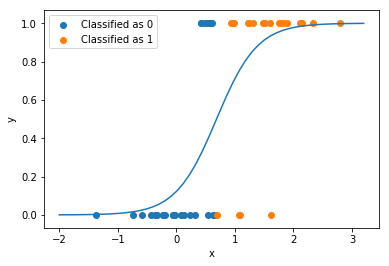

In [6]:
## ADD CODE HERE
# Fit and plot the logistic regression

#@solution
theta_ml = max_lik_estimate(x, y)
y_hat = predict(x, theta_ml).squeeze()
plt.scatter(x[y_hat < 0.5,1], y[y_hat < 0.5])
plt.scatter(x[y_hat > 0.5,1], y[y_hat > 0.5])
plt.legend(['Classified as 0', 'Classified as 1'])
plt.plot(x_test[:,1], 1.0/(1 + np.exp(-x_test @ theta_ml)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#@template
#@end

There you go! That should be a nice and easy fit. There are a few things we can start playing with at this point:

* Evaluate the performance of your model: plot the decision boundary, likelihood and accuracy on held-out test sets, etc.
* Write a gradient-based and a non-gradient-based optimizer. Do they arrive at the same result? Which one takes longer? Which one evaluates the likelihood function more times?

(Warning: if the plot looks odd and you get several warnings, it may be that the data is linearly separable and the sigmoid is saturating, leading to `np.log(0)` numerical problems. Add more noise and retry.)

## Bayesian logistic regression

### MAP estimate

Now let's move to Bayesian inference on the parameters $\boldsymbol\theta$. Let's put a prior on them. Because that's what we do. We put priors on things.

More specifically, let's use a Gaussian prior parametrised by a mean $\boldsymbol m$ and a variance $\boldsymbol S$:

$$\boldsymbol\theta \sim  \mathcal{N}(\boldsymbol m, \boldsymbol S)$$

Given that $\boldsymbol\theta_{\mathrm{ML}}$ had no analytical solution, it should really come as no surprise that $\boldsymbol\theta_{\mathrm{MAP}}$ doesn't either. That should be no problem for a machine learning expert like you:

1. Write down the equation for the full unnormalised posterior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y) \propto p(\boldsymbol y | \boldsymbol\theta, \boldsymbol X) p(\boldsymbol\theta)$.
2. Write a separate function for it, as we did with the log-likelihood above.
3. Optimise it to find $\boldsymbol\theta_{\mathrm{MAP}}$ and use it to make predictions.

In [7]:
## EDIT THIS FUNCTION
def map_estimate(X, y, m, S):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # m: D x 1 prior mean of parameters
    # S: D x D prior covariance of parameters
    # returns: maximum a posteriori parameters (D x 1)
    
    N, D = X.shape
    #@solution
    prior_L = scipy.linalg.cho_factor(S)
    def neg_log_post(arg):
        th = arg.reshape(-1,1)
        p = 1.0/(1 + np.exp(-X @ th))
        prior_term = 0.5*np.sum(scipy.linalg.cho_solve(prior_L, th - m)**2)
        likelihood_term = - np.sum(y*np.log(p) + (1-y)*np.log(1 - p))
        return likelihood_term + prior_term
    
    theta_init = rn.rand(D,1)
    theta_map = optimize.minimize(neg_log_post, theta_init)['x'].reshape(-1,1)
    #@template
    # theta_map = np.zeros((D,1)) ## <-- EDIT THIS LINE
    #@end
    return theta_map

Now you can perform a similar model evaluation as you did before. How does your prior influence the MAP estimate and the model's performance?

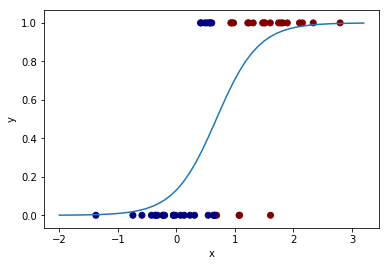

In [8]:
## ADD CODE HERE
# Fit and plot the MAP logistic regression estimate

m = np.zeros((D, 1))
S = 5*np.eye(D)

#@solution
theta_map = map_estimate(x, y, m, S)
y_hat = predict(x, theta_map)
plt.scatter(x[:,1], y, c=y_hat, cmap='jet')
plt.plot(x_test[:,1], 1.0/(1 + np.exp(-x_test @ theta_map)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#@template
#@end

### The Laplace approximation

As we have hinted above, in logistic regression the posterior distribution over $\boldsymbol\theta$ doesn't have an analytical solution. This is the first example in the course of _approximate Bayesian inference_: instead of calculating the exact posterior (as we did with linear regression and GPs), we'll have to approximate it using one of various techniques. The one we'll use in this part of the tutorial is called the **Laplace approximation**.

In brief, **the Laplace approximation consists of a Gaussian centered in the peak of the pdf of interest with the same curvature**. Let's make this a bit more rigorous below.

Let's say we have a probability distribution $p(z)$ we want to approximate. The distribution $p(z)$ is of the form

$$p(z) = \frac{1}{Z} \hat{p}(z) ~ ,$$

where $\hat{p}(z)$ is an unnormalised distribution that we can access easily, but $Z$ is unknown. Formally, the Laplace approximation results from a second order Taylor expansion of $\log \hat{p}(z)$:

$$\log \hat{p}(z) \approx \log \hat{p}(z_0) + \frac{d}{dz}\log \hat{p}(z)\Big|_{z=z_0}(z - z_0) + \frac{1}{2}\frac{d^2}{dz^2} \log \hat{p}(z)\Big|_{z=z_0}(z-z_0)^2$$

Now let's evaluate this expression at the mode of $p(z)$ -- which is the same as the mode of $\hat{p}(z)$. We define the mode $z^*$ such that

$$\frac{d}{dz} \hat{p}(z) \Big|_{z = z^*} = 0 ~ .$$

At this point, the $\mathcal{O}(z)$ term of the expansion vanishes and we are left with

$$\log \hat{p}(z) \approx \log \hat{p}(z^*) - \frac{1}{2}A(z-z^*)^2$$

Or, equivalently,

$$\hat{p}(z) \approx \hat{p}(z^*) \exp(-\frac{A}{2}(z - z^*)^2) ~ ,$$

where

$$A = - \frac{d^2}{dz^2} \log \hat{p}(z)\Big|_{z=z^*} ~ .$$

And now this distribution we know how to normalise, because it's one of those Gaussians we know and love. By inspection, we can identify the mean and the covariance, and write down the Laplace approximation of $p(z)$ as

$$q(z) = \mathcal{N}(z | z^*, A^{-1})$$

As an example, let's use the unnormalised distribution $\hat{p}(z) = x e^{-x/2}$. When normalised properly, this is in fact the $\chi^2$ distribution with $k=4$ degrees of freedom. Have a go yourself:

1. Plot $p(z)$.
2. Take the first derivative of $\hat{p}(z)$ (or the first derivative of its log), and find its maximum $z^*$ analytically.
3. In the same plot, draw a vertical line at $z = z^*$ to verify you got the right answer.
4. Take the second derivative of $\log \hat{p}(z)$ and evaluate it at $z^*$.
5. Plot the corresponding Gaussian $q(z)$ and verify the approximation looks reasonable.

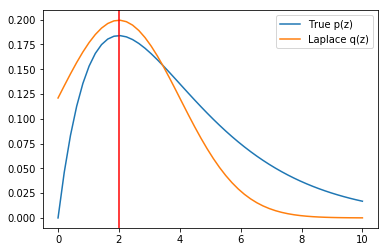

In [9]:
## ADD CODE HERE
# Find the Laplace approximation of x*exp(-x/2) with pen and paper and then plot it.
z = np.linspace(0,10)
p_hat = z*np.exp(-z/2)
p = stats.chi2.pdf(z, 4)

#@solution
z_star = 2
A = 1/4
q = stats.norm.pdf(z, z_star, 1/np.sqrt(A))
plt.plot(z, p)
plt.plot(z, q)
plt.legend(['True p(z)', 'Laplace q(z)'])
plt.axvline(z_star, c='r')
plt.show()
#@template
#@end

### Bayesian logistic regression (for real this time)

Now we have obtained the mode (peak) of the posterior through the MAP estimate above, it's time to go all the way and calculate the posterior over $\boldsymbol\theta$. However, as we mentioned above the posterior doesn't have an analytical form, so we'll use -- you guessed it -- the Laplace transform.

1. Write a function, based on your previous code, that will calculate the Laplace approximation $q(\boldsymbol\theta)$ of the true prior $p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$ and return the mean and variance of $q$.
2. To visualise the behaviour and the diversity of $q$, draw a number $j = 1, ... J$ of samples $\boldsymbol\theta_j \sim q(\boldsymbol\theta)$. For each sample, plot its predicted class probabilities $\sigma(x \boldsymbol\theta_j)$.

_Hint_: the extension of the Laplace approximation to multivariate distributions is straightforward, and in this case the variance of the Gaussian is the Hessian of the log likelihood $A = - \nabla_\theta \nabla_\theta \log p(\boldsymbol\theta | \boldsymbol X, \boldsymbol y)$.

In [10]:
## EDIT THIS FUNCTION
def get_posterior(X, y, m, S):
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # m: D x 1 prior mean of parameters
    # S: D x D prior covariance of parameters
    # returns: maximum a posteriori parameters (D x 1)
    #          covariance of Laplace apprx (D x D)

    #@solution
    theta_map = map_estimate(X, y, m, S)
    p = 1.0/(1 + np.exp(-X @ theta_map))
    R = np.diag((p*(1-p)).squeeze())
    S_post_inv = np.linalg.inv(S) + X.T @ R @ X

    mu_post = theta_map
    S_post = np.linalg.inv(S_post_inv)
    
    #@template
    # mu_post = np.zeros((D, 1)) ## <-- EDIT THESE LINES
    # S_post  = np.eye(D)
    #@end
    
    return mu_post, S_post

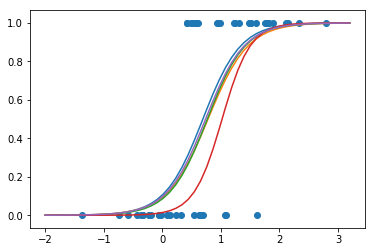

In [11]:
## ADD CODE HERE
# Calculate the Laplace posterior for theta, draw a few samples and plot
# the corresponding likelihood functions for each one.
m = np.zeros((D, 1))
S = 5*np.eye(D)
nb_samples = 5

theta_map, S_post = get_posterior(x, y, m, S)
plt.scatter(x[:,1], y)
for i in range(nb_samples):
    #@solution
    L_post = scipy.linalg.cho_factor(S_post)[0]
    th = theta_map + L_post @ rn.randn(D,1)
    plt.plot(x_test[:,1], 1.0/(1 + np.exp(-x_test @ th)))
    #@template
    # plt.plot() ## <--EDIT THIS LINE
    #@end
plt.show()

## Comparing posterior approximations

The Laplace approximation is part of a family of methods known as _deterministic approximate inference_. In addition, there's another set of methods known as _stochastic approximate inference_ which, as you can guess includes most of the sampling techniques you have studied.

You must be an expert in sampling by now. Let's actually go and check whether this Laplace approximation we just made is legit.

* What sampling methods do you know to sample from an unnormalized distribution?

For example, let's try the Metropolis algorithm.

1. Write a proposal function to move in $\boldsymbol\theta$-space.
2. Write a function to accept or reject new proposals based on the Metropolis criterion.
3. Write a loop and run the Markov chain for a few thousand iterations.
4. Check that the sampling worked: did the Markov chain mix properly? What's the acceptance rate? How does it depend on the proposal function?

In [12]:
## ADD CODE HERE
# Write a sampler to sample from the logistic posterior p(\theta|X,y)

#@solution
nb_iter = 10000
step_size = 0.5
samples = np.zeros((nb_iter, D))
th_last = np.zeros((D, 1))
Lp_last = -np.inf
prior_chol = scipy.linalg.cho_factor(S)
count = 0
for i in range(nb_iter):
    th_prop = th_last + step_size*rn.randn(D,1)

    p = 1.0/(1 + np.exp(-x @ th_prop))
    prior_term = - 0.5*np.sum(scipy.linalg.cho_solve(prior_chol, th_prop - m)**2)
    likelihood_term = np.sum(y*np.log(p) + (1-y)*np.log(1 - p))
    Lp_prop = likelihood_term + prior_term

    if rn.rand() < np.exp(Lp_prop - Lp_last):
        # Accept
        th_last = th_prop
        Lp_last = Lp_prop
        count = count + 1
    samples[i] = th_last.squeeze()
    
print('Acceptance rate: %f'%(count/nb_iter))
#@template
#@end

Acceptance rate: 0.533600


Finally, let's plot the results and see if both inference methods arrive at roughly the same posterior.

In the same axis, plot

* The histogram pdf of the MCMC samples (you may want to look at the `normed` option in `plt.hist`); and
* The Laplace posterior.

Make one plot for the intercept ($\theta_0$) and one for the slope ($\theta_1$). How do they look like? Do they match? What kinds of posteriors do you think the Laplace approximation will be good or bad at approximating?

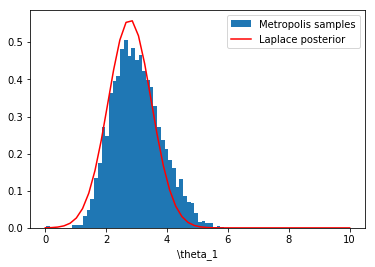

In [13]:
## ADD CODE HERE
# Plot a histogram of the MCMC posterior samples and the
# analytical expression for the Laplace posterior. If
# everything went well, the peaks should coincide and
# their widths should be comparable.

#@solution
_,_,h1 = plt.hist(samples[:,1], bins=50, normed=True)
h2, = plt.plot(np.linspace(0,10),
         stats.multivariate_normal.pdf(np.linspace(0,10), theta_map[1], S_post[1,1]), 'r')
plt.legend([h1[0], h2], ['Metropolis samples', 'Laplace posterior'])
plt.xlabel(r'\theta_1')
plt.show()
#@template
#@end

Et violà! Now you're an expert in logistic regression. (Wait, I think that's a big violin. I meant to say: et voilà!)

Now we can visualise the posterior we can play around with the data and the inference parameters:

* Play around with the data generation process. What happens as you increase/decrease $N$ and the jitter parameter?
* How does the joint posterior look? Make a visualisation of the MCMC and Laplace approximations in the $(\theta_0, \theta_1)$ plane.
* What happens if the model is misspecified? Take out the intercept term in the model (i.e. remove the column of ones in $X$), but set the `offset` in the data generation process to non-zero. What happens to the posterior and its Laplace approximation?
